# Imports

In [97]:
import os
import cv2 as cv
import numpy as np
import scipy.fftpack as fp
import matplotlib.pylab as plt

import pywt
from skimage import color
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import random_noise
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from skimage.metrics import peak_signal_noise_ratio as psnr

# Utils

In [98]:
def plot_image(img, title, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.title(title, size=10)

def plot_freq_spec_3d(ax, freq):
    Y = np.arange(-freq.shape[0] // 2, freq.shape[0] - freq.shape[0] // 2)
    X = np.arange(-freq.shape[1] // 2, freq.shape[1] - freq.shape[1] // 2)
    X, Y = np.meshgrid(X, Y)
    Z = (20 * np.log10(0.01 + np.fft.fftshift(freq))).real
    ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=True)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_zlim(-40, 120)

def plot_img_and_freq(image, title):
    fig = plt.figure(figsize=(9, 4))

    plt.subplot(131)
    plot_image(image, title)

    ax = fig.add_subplot(132, projection='3d')
    plot_freq_spec_3d(ax, np.fft.fft2(image))

    plt.tight_layout()

In [99]:
def convolve2d(im, psf, k):
    """
    Perform 2D convolution between an image and a point spread function (PSF).

    Parameters:
    - im: numpy.ndarray
        Input image.
    - psf: numpy.ndarray
        Point spread function.
    - k: int
        Size of the PSF kernel.

    Returns:
    - numpy.ndarray
        Convolved image.
    """
    M, N = im.shape
    freq = fp.fft2(im)
    psf = np.pad(psf, (((M - k) // 2, (M - k) // 2 + 1), ((N - k) // 2, (N - k) // 2 + 1)), mode='constant')
    freq_kernel = fp.fft2(fp.ifftshift(psf))
    return np.abs(fp.ifft2(freq * freq_kernel))

# Reference image

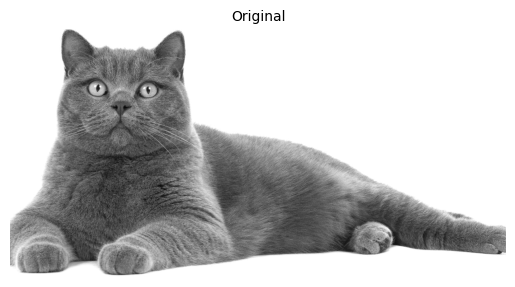

In [105]:
img = cv.imread('images/cat.jpeg', cv.IMREAD_GRAYSCALE)
plot_image(img, 'Original')

# Noise types

In [106]:
# Noise functions for uint8 images
def add_gaussian_noise(image, mean=0, sigma=25):
    row, col = image.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_poisson_noise(image):
    noisy = np.random.poisson(image)
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_impulsiv_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy = np.copy(image)
    total_pixels = image.size

    # Add salt noise
    salt_pixels = int(total_pixels * salt_prob)
    salt_coords = [np.random.randint(0, i - 1, salt_pixels) for i in image.shape]
    noisy[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise
    pepper_pixels = int(total_pixels * pepper_prob)
    pepper_coords = [np.random.randint(0, i - 1, pepper_pixels) for i in image.shape]
    noisy[pepper_coords[0], pepper_coords[1]] = 0

    return noisy.astype(np.uint8)

def add_speckle_noise(image):
    speckle = np.random.standard_normal(image.shape)
    noisy = image + image * speckle
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_exponential_noise(image, scale=25):
    expo = np.random.exponential(scale, image.shape)
    noisy = image + expo
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_rayleigh_noise(image, scale=25):
    rayleigh = np.random.rayleigh(scale, image.shape)
    noisy = image + rayleigh
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_uniform_noise(image, low=0, high=50):
    # Quantization noise
    uniform = np.random.uniform(low, high, image.shape)
    noisy = image + uniform
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_periodic_noise(image, frequency=6, amplitude=50):
    rows, cols = image.shape
    y = np.linspace(0, frequency * 2 * np.pi, rows)
    yy = np.tile(y, (cols, 1)).T  # Tile the y values to cover the entire image horizontally
    noise = amplitude * np.sin(yy)
    noisy = image + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

In [107]:
noise_types = ['Gaussian', 'Poisson', 'Impulsiv', 'Speckle', 'Exponential', 'Rayleigh', 'Uniform', 'Periodic']

noisy_images = []
noise_hist = []

# Salvam intr-o lista imaginile cu zgomot si histogramele zgomotelor
for noise_type in noise_types:
    noise_func = globals()[f'add_{noise_type.lower().replace(" ", "_")}_noise']
    noisy_images.append(noise_func(img))
    noise_hist.append((noisy_images[-1] - img).astype(np.uint8))

In [108]:
for i in range(8):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im = noisy_images[i]
    axs[0].imshow(im, cmap='gray')
    axs[0].axis('off')

    noise = noise_hist[i]
    if i <= 1:
        axs[1].hist(np.ravel(noise[(noise != 0) & (noise <= 255)]), bins=60, alpha=0.5, color='green')
    else:
        axs[1].hist(np.ravel(noise[noise != 0]), bins=60, alpha=0.5, color='green')
    axs[1].grid()

    plt.tight_layout()
    # plt.savefig(f'images/{noise_types[i]}_plot.eps', bbox_inches='tight', format='eps')
    plt.close()

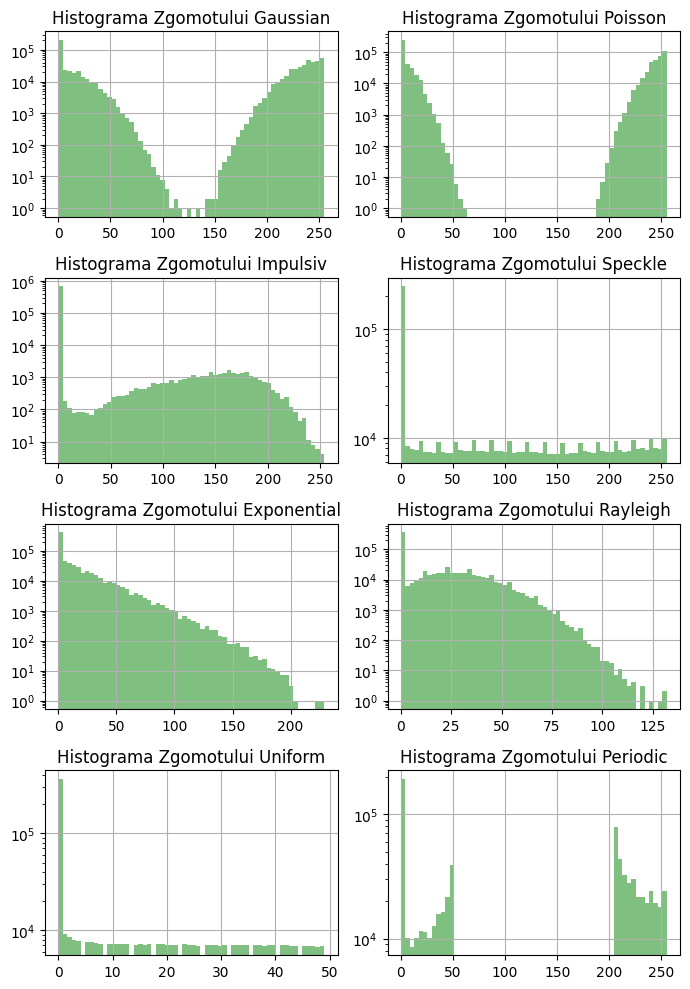

In [109]:
fig, axs = plt.subplots(4, 2, figsize=(7, 10))
for i, noise in enumerate(noise_hist):
    axs[i // 2, i % 2].hist(np.ravel(noise), bins=60, alpha=0.5, color='green')
    axs[i // 2, i % 2].set_title(f'Histograma Zgomotului {noise_types[i]}')
    axs[i // 2, i % 2].grid()
    axs[i // 2, i % 2].tick_params()
    axs[i // 2, i % 2].set_yscale('log')

plt.tight_layout()
# plt.savefig('images/noise_histograms.eps', bbox_inches='tight', format='eps')
plt.show()

# Linear Filters

In [89]:
def uniform_filter(image, kernel_size):
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_width=pad_size, mode='constant', constant_values=0)
    result = np.zeros_like(image)

    for i in range(pad_size, image.shape[0] + pad_size):
        for j in range(pad_size, image.shape[1] + pad_size):
            neighborhood = padded_image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]
            result[i-pad_size, j-pad_size] = np.mean(neighborhood)

    return result

def median_filter(image, kernel_size):
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_width=pad_size, mode='constant', constant_values=0)
    result = np.zeros_like(image)

    for i in range(pad_size, image.shape[0] + pad_size):
        for j in range(pad_size, image.shape[1] + pad_size):
            neighborhood = padded_image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]
            result[i-pad_size, j-pad_size] = np.median(neighborhood)

    return result

## Filtrul de Medie

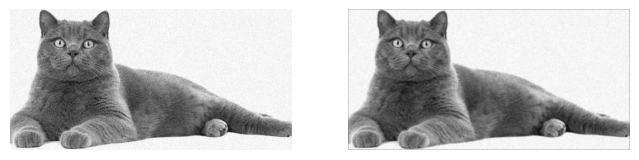

In [90]:
noisy_img = add_gaussian_noise(img, sigma=25)
plt.figure(figsize=(8, 4))
plt.subplot(121), plt.imshow(noisy_img, cmap='gray')
plt.axis('off')
plt.subplot(122), plt.imshow(uniform_filter(noisy_img, 5), cmap='gray')
plt.axis('off')
plt.savefig('images/filtru_medie.eps', bbox_inches='tight', format='eps')
plt.show()

## Filtrul Median

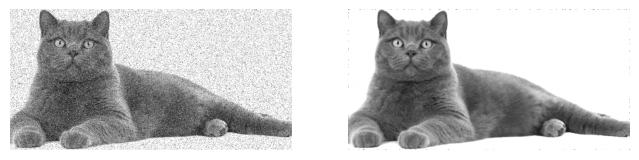

In [91]:
noisy_img = add_impulsiv_noise(img, salt_prob=0.1, pepper_prob=0.1)
plt.figure(figsize=(8, 4))
plt.subplot(121), plt.imshow(noisy_img, cmap='gray')
plt.axis('off')
plt.subplot(122), plt.imshow(median_filter(noisy_img, 5), cmap='gray')
plt.axis('off')
plt.savefig('images/filtru_median.eps', bbox_inches='tight', format='eps')
plt.show()

# Aplicarea Filtrelor asupra tuturor tipurilor de zgomot

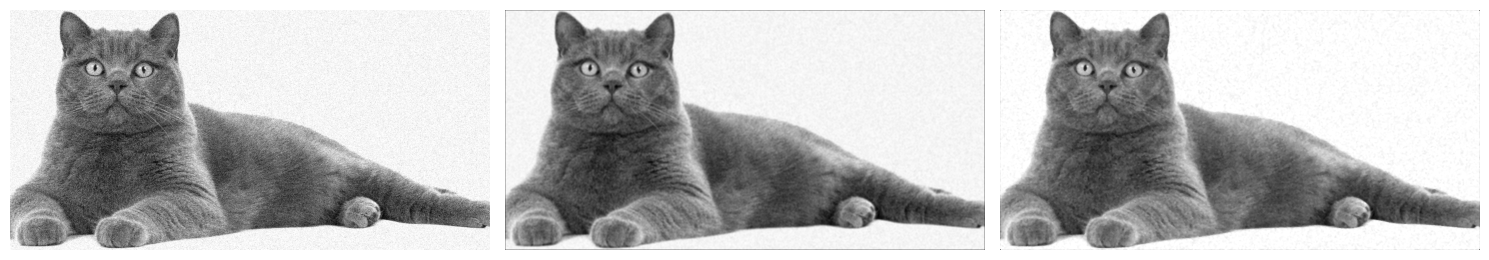

PSNR pentru Gaussian (cu zgomot): 21.44
PSNR pentru Gaussian (medie): 23.76
PSNR pentru Gaussian (mediana): 26.16
----------------------------------------


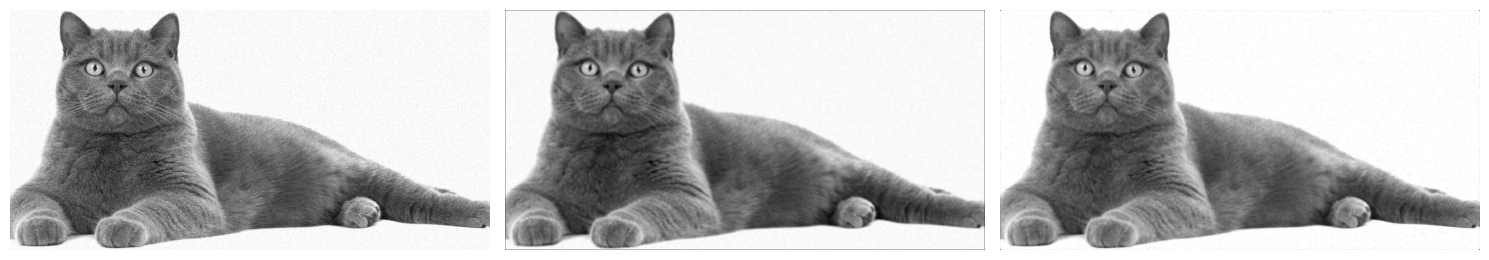

PSNR pentru Poisson (cu zgomot): 27.36
PSNR pentru Poisson (medie): 24.66
PSNR pentru Poisson (mediana): 26.98
----------------------------------------


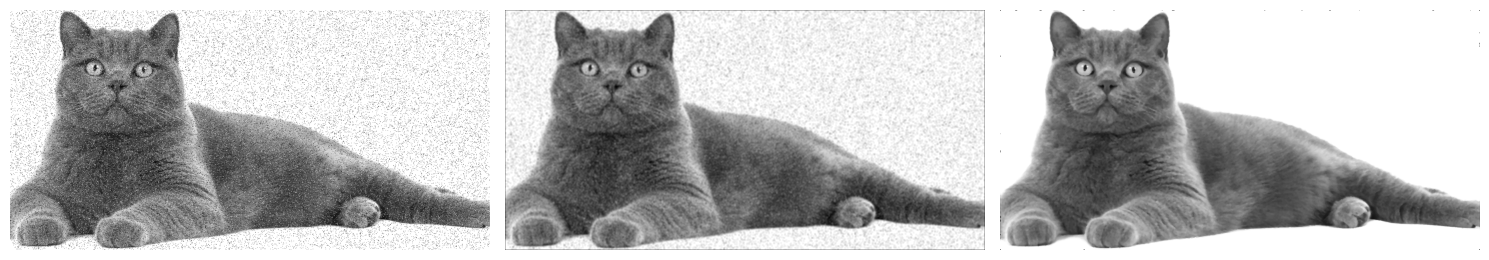

PSNR pentru Impulsiv (cu zgomot): 14.23
PSNR pentru Impulsiv (medie): 22.25
PSNR pentru Impulsiv (mediana): 27.02
----------------------------------------


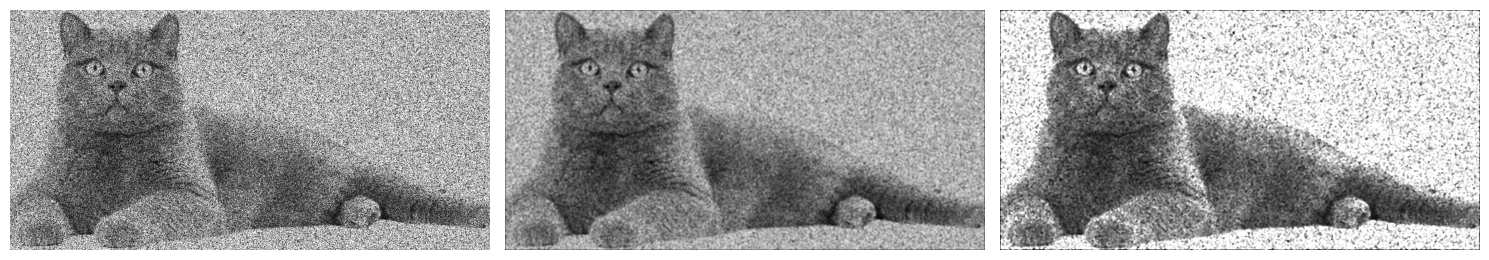

PSNR pentru Speckle (cu zgomot): 7.35
PSNR pentru Speckle (medie): 12.09
PSNR pentru Speckle (mediana): 15.49
----------------------------------------


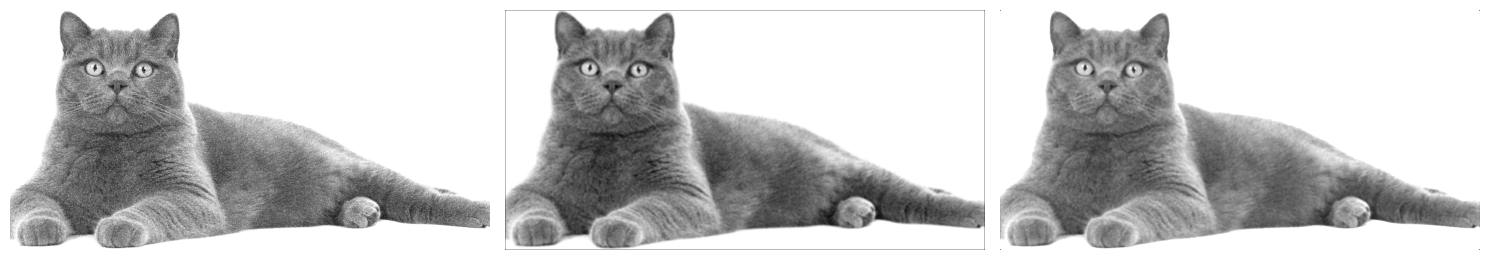

PSNR pentru Exponential (cu zgomot): 20.65
PSNR pentru Exponential (medie): 21.38
PSNR pentru Exponential (mediana): 22.87
----------------------------------------


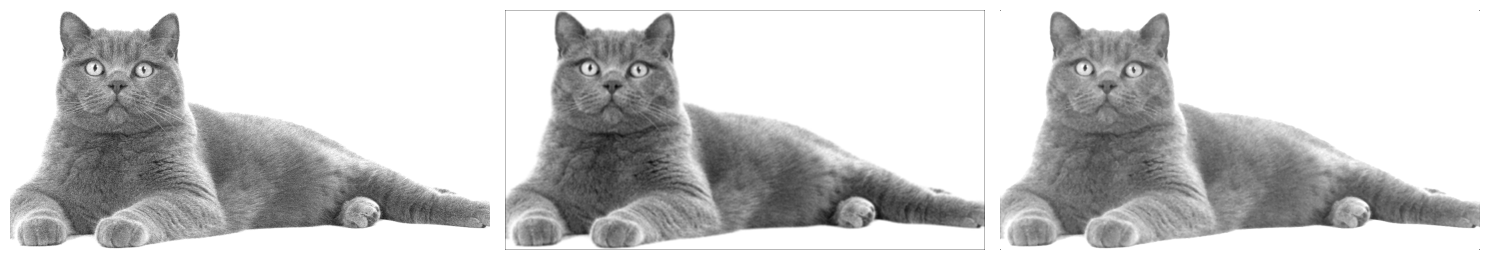

PSNR pentru Rayleigh (cu zgomot): 20.44
PSNR pentru Rayleigh (medie): 20.07
PSNR pentru Rayleigh (mediana): 20.61
----------------------------------------


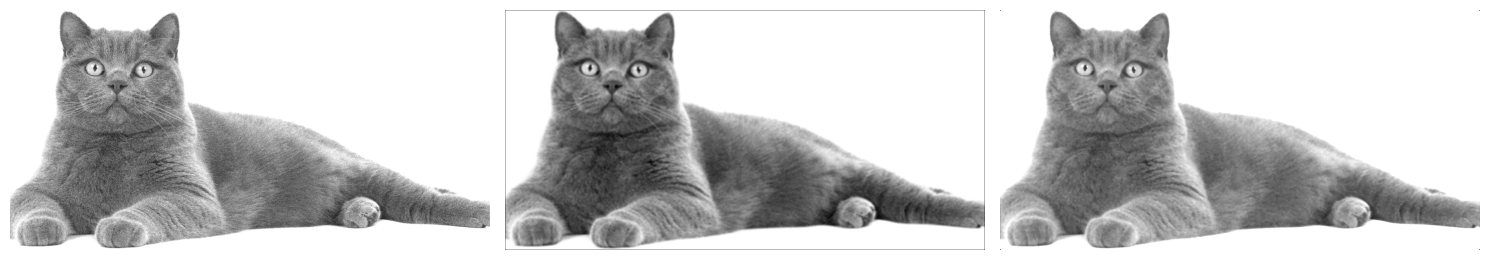

PSNR pentru Uniform (cu zgomot): 22.19
PSNR pentru Uniform (medie): 21.38
PSNR pentru Uniform (mediana): 21.89
----------------------------------------


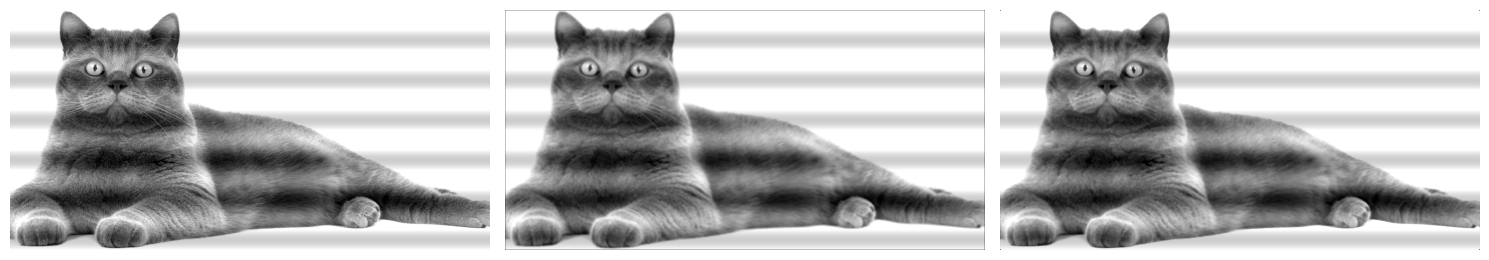

PSNR pentru Periodic (cu zgomot): 18.41
PSNR pentru Periodic (medie): 17.60
PSNR pentru Periodic (mediana): 17.90
----------------------------------------


In [96]:
def save_and_display_linear_filters(orig_img, noisy_images: list, noise_types: list, kernel_size=5):
    for i, noisy_img in enumerate(noisy_images):
        # PSNR pentru imaginea cu zgomot
        psnr_noisy = psnr(orig_img, noisy_img)

        # Filtrarea (medie)
        filtered_mean = uniform_filter(noisy_img, kernel_size)
        psnr_mean = psnr(orig_img, filtered_mean)

        # Filtrarea (mediana)
        filtered_median = median_filter(noisy_img, kernel_size)
        psnr_median = psnr(orig_img, filtered_median)

        # Salvarea imaginii în format EPS
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Imaginea cu zgomot
        axs[0].imshow(noisy_img, cmap='gray')
        axs[0].axis('off')

        # Denoised Image (mean)
        axs[1].imshow(filtered_mean, cmap='gray')
        axs[1].axis('off')

        # Denoised Image (median)
        axs[2].imshow(filtered_median, cmap='gray')
        axs[2].axis('off')

        plt.tight_layout()
        plt.savefig(f'images/row_{i+1}_filters.eps', bbox_inches='tight', format='eps')
        plt.show()
        plt.close()

        # Afișarea PSNR-urilor în consolă
        print(f"PSNR pentru {noise_types[i]} (cu zgomot): {psnr_noisy:.2f}")
        print(f"PSNR pentru {noise_types[i]} (medie): {psnr_mean:.2f}")
        print(f"PSNR pentru {noise_types[i]} (mediana): {psnr_median:.2f}")
        print("-" * 40)

# Apelarea funcției pentru a salva și afișa rezultatele
save_and_display_linear_filters(img, noisy_images, noise_types, kernel_size=5)

# Filtre Spațiale

In [110]:
img = rgb2gray(cv.imread('images/cat.jpeg'))

noisy = img.copy()
noisy += 0.3 * img.std() * np.random.standard_normal(img.shape)

## Discrete Fourier Transform

In [151]:
def dft_2d(img, r=30):
    # Step 1: Apply 2D Fourier Transform
    f_transform = fp.fft2(img)

    # Step 2: Shift the DC component to the center
    f_transform_shifted = fp.fftshift(f_transform)
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(np.log(np.abs(f_transform_shifted) + 1), cmap='gray')
    plt.axis('off')
    # plt.title('Shifted Fourier Transform'), plt.axis('off')

    # Step 3: Design an ideal low-pass filter
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 > r*r
    mask[mask_area] = 0

    plt.subplot(122), plt.imshow(mask, cmap='gray')
    plt.axis('off')
    # plt.title('Low-pass Filter'), plt.axis('off')
    plt.savefig(f'images/low_pass_filter.eps', format='eps', bbox_inches='tight')
    plt.show()

    # Step 4: Apply the filter
    f_transform_shifted_filtered = f_transform_shifted * mask
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(np.log(np.abs(f_transform_shifted_filtered) + 1), cmap='gray')
    plt.axis('off')
    # plt.title('Filtered Fourier Transform'), plt.axis('off')

    # Step 5: Inverse Fourier Transform
    img_denoised = np.fft.ifft2(np.fft.ifftshift(f_transform_shifted_filtered)).real
    plt.subplot(122), plt.imshow(img_denoised, cmap='gray')
    plt.axis('off')
    # plt.title('Inverse Fourier Transform'), plt.axis('off')
    plt.savefig(f'images/inverse_fourier_transform.eps', format='eps', bbox_inches='tight')
    plt.show()

    return img_denoised

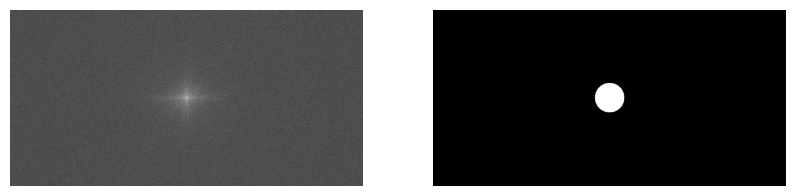

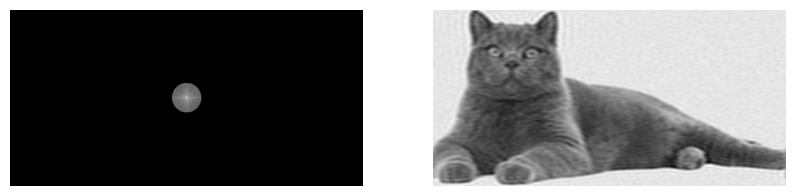

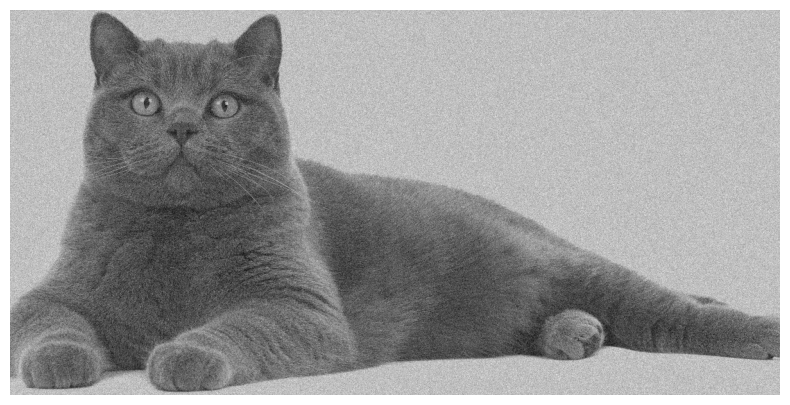

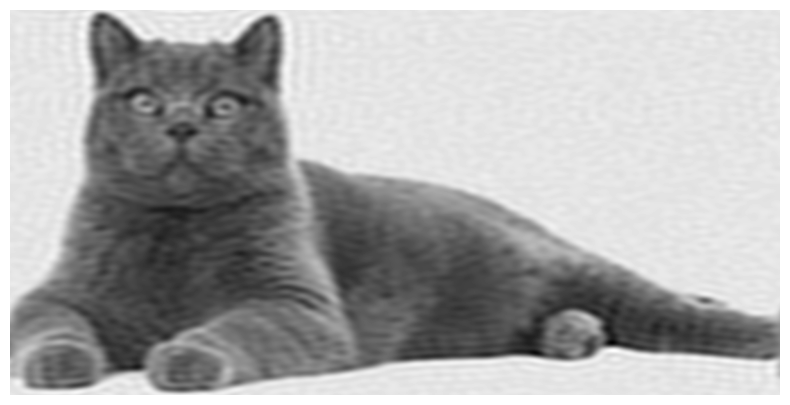

In [152]:
denoised = dft_2d(noisy, r=50)

# Noisy Image
plt.figure(figsize=(10, 5))
plt.imshow(noisy, cmap='gray')
# plt.title(f'Noisy, PSNR={psnr(img, noisy):.2f}')
plt.axis('off')
plt.savefig(f'images/noisy_image.eps', format='eps', bbox_inches='tight')
plt.show()

# Denoised Image (DFT)
plt.figure(figsize=(10, 5))
plt.imshow(denoised, cmap='gray')
# plt.title(f'Denoised (DFT), PSNR={psnr(img, denoised):.2f}')
plt.axis('off')
plt.savefig(f'images/denoised_dft.eps', format='eps', bbox_inches='tight')
plt.show()

## Discrete Wavelet Transform

In [124]:
!pip install PyWavelets

In [156]:
# https://asp-eurasipjournals.springeropen.com/articles/10.1186/s13634-020-00693-4
def dwt_denoise(img, wavelet='haar', level=1):
    """
    Apply denoising using Discrete Wavelet Transform (DWT) to the input image.

    Parameters:
    - img: Input image to be denoised.
    - wavelet: Wavelet function to be used for DWT. Default is 'haar'.
    - level: Number of decomposition levels for DWT. Default is 1.

    Returns:
    - img_denoised: Denoised image after applying DWT.

    """
    # Step 1: Decompose the image using DWT
    coeffs = pywt.wavedec2(img, wavelet, level=level)

    # Step 2: Set threshold for denoising
    threshold = 20

    # Step 3: Threshold the detail coefficients
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') if i > 0 else c for i, c in enumerate(coeffs)]

    coeffs_thresholded_explicit = [tuple(coeffs_thresholded[0])] + [tuple(c) for c in coeffs_thresholded[1:]]

    # Step 4: Reconstruct the denoised image
    img_denoised = pywt.waverec2(coeffs_thresholded_explicit, wavelet)


    return img_denoised

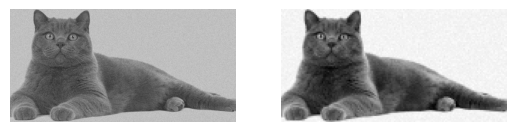

Image PSNR=20.65
Denoised PSNR=24.35


In [161]:
denoised = dwt_denoise(noisy, level=3)

plt.subplot(121), plt.imshow(noisy, cmap='gray')
plt.axis('off')
plt.subplot(122), plt.imshow(denoised, cmap='gray')
plt.axis('off')
plt.savefig(f'images/dwt_img3.eps', format='eps', bbox_inches='tight')
plt.show()

print(f'Image PSNR={psnr(img, noisy):.2f}')
print(f'Denoised PSNR={psnr(img, denoised):.2f}')

# Wiener Filter

In [73]:
def wiener(image, psf, balance=0.1):
    image_freq = fp.fft2(image)

    M, N = image.shape
    psf = np.pad(psf, (((M - psf.shape[0]) // 2, (M - psf.shape[0]) // 2 + 1),
                       ((N - psf.shape[1]) // 2, (N - psf.shape[1]) // 2 + 1)), mode='constant')
 
    psf_freq = fp.fft2(fp.ifftshift(psf))
    wiener_filter = np.conj(psf_freq) / (np.abs(psf_freq) ** 2 + balance)
    restored_freq = image_freq * wiener_filter
    restored_image = np.abs(fp.ifft2(restored_freq))

    return restored_image

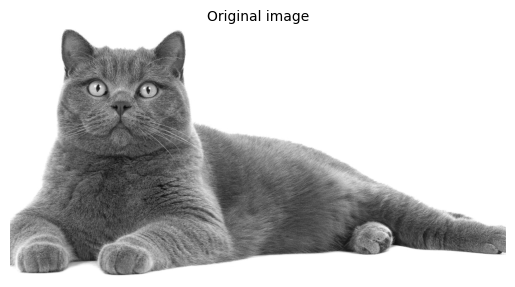

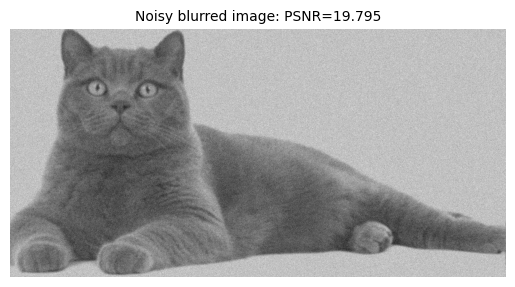

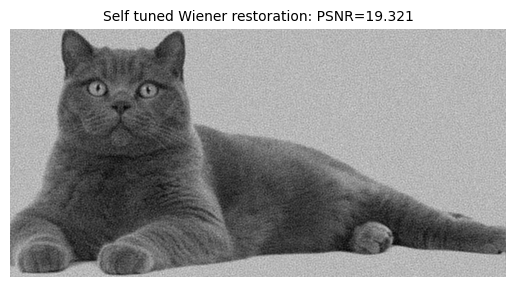

PSNR imaginea cu zgomot: 19.795082507294254
PSNR imaginea filtrata: 19.3210494553998


In [115]:
k = 5
psf = np.ones((k, k)) / k ** 2

im = color.rgb2gray(imread('images/cat.jpeg'))
im1 = convolve2d(im, psf, k)
im1 += 0.3 * im.std() * np.random.standard_normal(im.shape)
im2 = wiener(im1, psf, balance=0.1)

titles = [
    'Original image',
    'Noisy blurred image: PSNR={:.3f}'.format(psnr(im, im1)),
    'Self tuned Wiener restoration: PSNR={:.3f}'.format(psnr(im, im2)),
    # '',
    # '',
    # '',
]
images = [im, im1, im2]

for i in range(3):
    plot_image(images[i], titles[i])
    # plt.savefig(os.path.join('images', f"wiener_im{i+1}.eps"), bbox_inches='tight')
    plt.show()

print(f'PSNR imaginea cu zgomot: {psnr(im, im1)}')
print(f'PSNR imaginea filtrata: {psnr(im, im2)}')

# Constrained Least Squares (CLS) Filter

In [116]:
def cls_filter(y, h, c, lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf_conj = np.conj(Hf)
    Hf = Hf_conj / (Hf * Hf_conj + lambd * Cf * np.conj(Cf))
    Yf = fp.fft2(y)
    I = Yf * Hf
    return np.abs(fp.ifft2(I))

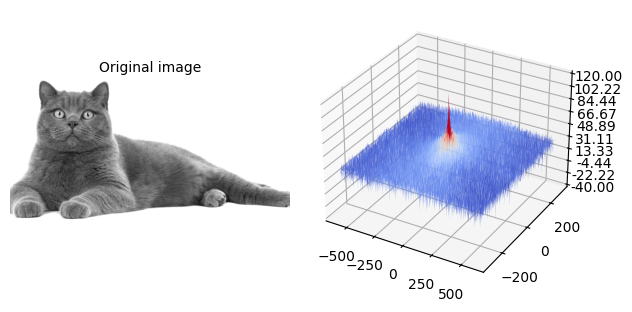

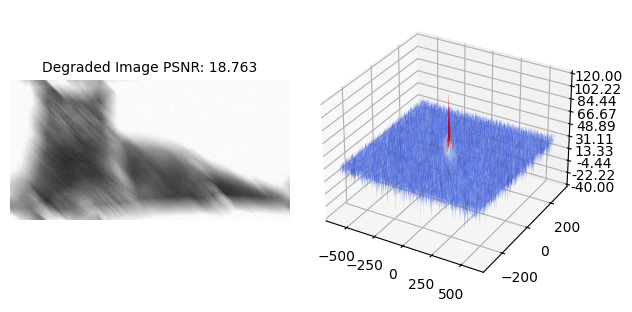

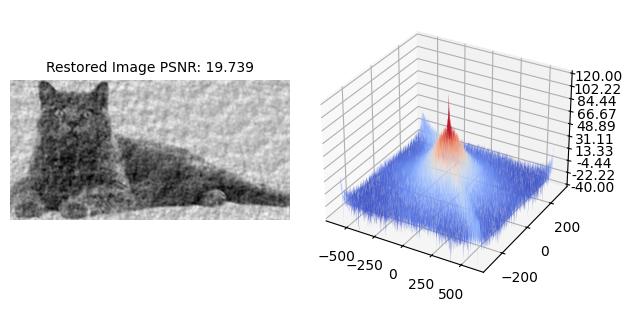

PSNR imaginea cu zgomot: 18.762518514165357
PSNR imaginea filtrata: 19.73863794755972


In [155]:
im = rgb2gray(imread('images/cat.jpeg'))

(M, N), k = im.shape, 81
kernel = np.eye(k) / k
im_blur = convolve2d(im, kernel, k)
im_blur = random_noise(im_blur, var=0.0025)

x, y, h = im, im_blur, kernel

pad_rows = (M // 2 - k // 2, M // 2 - k // 2 - 1)
pad_cols = (N // 2 - k // 2, N // 2 - k // 2 - 1)
h = np.pad(h, [pad_rows, pad_cols], mode='constant')

c = np.pad([[0, 1 / 4, 0], [1 / 4, -1, 1 / 4], [0, 1 / 4, 0]], [(M // 2 - 1, M // 2 - 2), (N // 2 - 2, N // 2 - 1)], mode='constant')
Cf = fp.fft2(fp.ifftshift(c))

_lambda = 2
clx = cls_filter(y, h, c, _lambda)

titles = [
    'Original image',
    'Degraded Image PSNR: {}'.format(np.round(psnr(x, y), 3)),
    'Restored Image PSNR: {}'.format(np.round(psnr(x, clx), 3))
]
images = [im, im_blur, clx]

for i in range(3):
    plot_img_and_freq(images[i], titles[i])
    # plt.savefig(os.path.join('images', f"cls_im{i+1}.eps"), bbox_inches='tight')
    plt.show()

print(f'PSNR imaginea cu zgomot: {psnr(im, im_blur)}')
print(f'PSNR imaginea filtrata: {psnr(im, clx)}')